In [1]:
import os
import fsspec
import numpy as np
from decord import VideoReader, gpu, cpu

import torch
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import LlavaNextVideoProcessor

NUM_FRAMES = 16 # adjtec for your use-case
MODEL_ID = "llava-hf/LLaVA-NeXT-Video-7B-hf"

processor = LlavaNextVideoProcessor.from_pretrained(MODEL_ID)
dataset = load_dataset("ShareGPT4Video/ShareGPT4Video")

preprocessor_config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

In [3]:
dataset


DatasetDict({
    train: Dataset({
        features: ['video_id', 'video_path', 'timestamp', 'keyframe', 'captions', 'zip_folder'],
        num_rows: 40178
    })
})

In [4]:
dataset['train'][0]


{'video_id': '02bd228227979a5663a155011f5e3740853f729d68bc12f8fefc75eeb7630379',
 'video_path': 'pixabay/02bd228227979a5663a155011f5e3740853f729d68bc12f8fefc75eeb7630379.mp4',
 'timestamp': ['00:00:00.000', '00:00:04.000'],
 'keyframe': [0.0, 2.0, 4.0],
 'captions': [{'idx': '1',
   'content': "The frame displays a person with a complexion that appears fair, as indicated by the visible shoulders and upper chest. The individual is clad in a dark tank top, the straps of which are slender, overlying the person's shoulders, suggesting a casual or athletic attire. There is a conspicuous contrast between the subject's light skin tone and the tank top's dark fabric, as well as against the background, which is predominantly dark. The background offers no discernible detail, thereby isolating the subject as the focal point. The lighting in the frame seems to be directed from the front, casting subtle shadows and highlighting the musculature and contours of the visible skin. The posture of the p

In [2]:
def read_video_decord(video_path, num_frames=NUM_FRAMES):
    '''
    Decode the video with Decord decoder.

    Args:
        video_path (str): Path to the video file.
        num_frames (int): Number of frames to sample uniformly. Defaults to NUM_FRAMES

    Returns:
        np.ndarray: np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    vr = VideoReader(uri=video_path, ctx=cpu(0)) # you need to install from source to use gpu ctx
    indices = np.arange(0, len(vr), len(vr) / num_frames).astype(int)
    frames = vr.get_batch(indices).asnumpy()
    return frames

In [26]:
class StreamerDataset(Dataset):
    """
    This dataset handles the loading of video data and corresponding captions for streaming purposes.
    It retrieves video data from a zip file stored remotely in HuggingFace Hub and processes it into tensors
    suitable for model input.
    """
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        curr_element = self.dataset[idx]
        zip_file_shard = curr_element['zip_folder']
        video_path = curr_element['video_path']
        file_name = curr_element["video_path"].split("/")[-1]
        zip_folder = curr_element["video_path"].split("/")[0]
        with fsspec.open(
            f"zip://{file_name}::hf://datasets/ShareGPT4Video/ShareGPT4Video/zip_folder/{zip_folder}/{zip_file_shard}"
        ) as f:
            video_clip = read_video_decord(f)

        # take caption for the whole video and not per-scene
        video_caption = [caption['content'] for caption in curr_element["captions"] if caption['idx'] == '-1'][0]
        
        # Let's use chat template to format the prompt correctly
        conversation = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Provide a detailed caption for this video."},
                        {"type": "video"},
                        ],
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": video_caption},
                        ],
                },
            ]

        prompt = processor.apply_chat_template(conversation, add_generation_prompt=False)
        
        inputs = processor(
            # text=video_caption, 
            text=prompt,
            videos=video_clip, 
            return_tensors="pt"
        )
        
        return inputs

    def __len__(self):
        return len(self.dataset)
    
    def get_video_frames_as_pil(self, idx):
        curr_element = self.dataset[idx]
        zip_file_shard = curr_element['zip_folder']
        video_path = curr_element['video_path']
        file_name = curr_element["video_path"].split("/")[-1]
        zip_folder = curr_element["video_path"].split("/")[0]
        with fsspec.open(
            f"zip://{file_name}::hf://datasets/ShareGPT4Video/ShareGPT4Video/zip_folder/{zip_folder}/{zip_file_shard}"
        ) as f:
            video_clip = read_video_decord(f)
        return video_clip

In [27]:
streamer = StreamerDataset(dataset["train"])

# streamer[0]
video_clip = streamer.get_video_frames_as_pil(0)

In [32]:
from datasets import Dataset as HFDataset

# convert streamer to HF dataset
# hf_dataset = HFDataset.from_dict({k: [v] for k, v in streamer[0].items()})

data_dict = {
    "input_ids": [],
    "attention_mask": [],
    "pixel_values_videos": []
}
for i in range(10):
    data = streamer[i]
    data_dict["input_ids"].append(data["input_ids"])
    data_dict["attention_mask"].append(data["attention_mask"])
    data_dict["pixel_values_videos"].append(data["pixel_values_videos"])
    
hf_dataset = HFDataset.from_dict(data_dict)

In [41]:
streamer[0]['pixel_values_videos'].shape

torch.Size([1, 16, 3, 336, 336])

In [36]:
hf_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'pixel_values_videos'],
    num_rows: 10
})

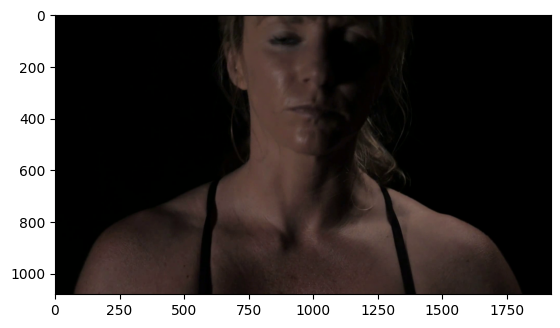

In [25]:
# show the first frame
import matplotlib.pyplot as plt
plt.imshow(video_clip[-1])

In [44]:
def collate_fn(examples):
    """
    Collate function that dynamically pads inputs to the max length within the batch and creates labels for language modelsing task.
    In contrast to DataCollatorForLanguageModeling, this collator adds pixel values to the batch for multimodal LLMs.
    """
    padded_inputs = processor.tokenizer.pad(
        {
            "input_ids": [feat['input_ids'][0] for feat in examples], # each element is one batch only so we slice [0]
            "attention_mask": [feat['attention_mask'][0] for feat in examples],
        },
        padding=True,
        return_tensors="pt",
    )

    labels = padded_inputs["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100 # feel free to mask labels the way that suits your use-case (e.g. mask all user-turns)
    padded_inputs["labels"] = labels
    padded_inputs["pixel_values_videos"] = torch.cat([feat['pixel_values_videos'] for feat in examples], dim=0)

    return padded_inputs

In [7]:
streamer = StreamerDataset(dataset["train"])
# loader = DataLoader(streamer, batch_size=8, collate_fn=collate_fn)

In [ ]:
# batch_items = next(iter(loader))

In [8]:
batch_items = streamer[0]

In [9]:
batch_items.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values_videos'])

In [ ]:
batch_items["input_ids"].shape

In [43]:
hf_dataset[0]["pixel_values_videos"].shape

AttributeError: 'list' object has no attribute 'shape'

In [45]:
hf_dataset = hf_dataset.map(
    lambda x: collate_fn([x]),
    batched=True,
    batch_size=2,
    # remove_columns=hf_dataset.column_names,
)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TypeError: expected Tensor as element 0 in argument 0, but got list

In [38]:
example = hf_dataset[0]


from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# convert to image from proceessed tensors
# example["pixel_values_videos"].shape # [1, 16, 3, 336, 336]
clip = example["pixel_values_videos"][0] * 255  # [16, 3, 336, 336]
clip = clip.permute(0, 2, 3, 1).clamp(0, 255)   # [16, 336, 336, 3]

# np array with shape (frames, height, width, channels)
video = np.array(clip).astype(np.uint8) # [16, 336, 336, 3]

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=100)
HTML(anim.to_html5_video())


AttributeError: 'list' object has no attribute 'permute'

In [15]:
video

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [11]:
processor.batch_decode(example["input_ids"])


["<s> The video features a person with a fair complexion, dressed in a dark tank top, against a dark, featureless background. Initially, the individual is in an upright and static position with direct lighting accentuating their skin's contours. As the video progresses, the person slightly leans forward, altering the shadow and angle on their shoulders, hinting at the start of a motion or gesture. This motion involves the person's right shoulder moving forward while the left rolls back. Shortly after, the individual returns to a more neutral and less inclined posture, suggesting the completion or reversal of the small movement. Throughout, the lighting slightly shifts, softening the shadows on the person's skin, and there is no camera movement, maintaining a static shot with a consistent angle and framing that keeps the focus exclusively on the individual's upper body."]